# Data Loading and Splitting

In [78]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

# Load and clean data
df = pd.read_csv("heart.csv")
df.columns = df.columns.str.strip()

# Identify categorical and numerical columns
cat_col = [col for col in df.columns if df[col].dtype == 'object']
num_col = [col for col in df.columns if (df[col].dtype in ['int64', 'float64']) 
          and (col != "HeartDisease")]

# Split data into features (X) and target (Y)
x = df.drop("HeartDisease", axis=1)
Y = df["HeartDisease"]

# Split into train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(
    x, Y, test_size=0.30, stratify=Y, random_state=42
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=42
)

# Reset indices to ensure alignment between features and labels
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Initialize encoders/scalers
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
scaler = StandardScaler()

# Process training data
x_train_cat = ohe.fit_transform(x_train[cat_col])
x_train_num = scaler.fit_transform(x_train[num_col])
x_train_processed = np.hstack([x_train_num, x_train_cat])

# Process validation/test data
x_val_cat = ohe.transform(x_val[cat_col])
x_val_num = scaler.transform(x_val[num_col])
x_val_processed = np.hstack([x_val_num, x_val_cat])

x_test_cat = ohe.transform(x_test[cat_col])
x_test_num = scaler.transform(x_test[num_col])
x_test_processed = np.hstack([x_test_num, x_test_cat])

# Get feature names
num_feature_names = num_col
cat_feature_names = ohe.get_feature_names_out(cat_col)
all_feature_names = num_feature_names + list(cat_feature_names)

# Create DataFrames with reset indices
x_train = pd.DataFrame(x_train_processed, columns=all_feature_names)
x_val = pd.DataFrame(x_val_processed, columns=all_feature_names)
x_test = pd.DataFrame(x_test_processed, columns=all_feature_names)

print(f"Training Set: {x_train.shape}, Validation: {x_val.shape}, Test: {x_test.shape}")

Training Set: (642, 20), Validation: (92, 20), Test: (184, 20)


# Stump class

In [ ]:
class Stump:
    def __init__(self):
        self.best_split = None
        self.best_threshold = None
        self.classification_direction = 1
        self.min_error = float("inf")
        self.weight = None
    
    def misclassification_error(self, y, predictions, sample_weights):
        return np.sum(sample_weights[predictions != y])
    
    def change_min_error(self, error, feature, threshold, direction):
        self.min_error = error
        self.best_split = feature
        self.best_threshold = threshold
        self.classification_direction = direction

    def fit(self, x, y, sample_weights):
        num_samples, num_features = x.shape

        # iterate over all features and all possible thresholds to find the best decision stump
        for feature in range(num_features):
            feature_values = np.unique(x[:, feature])
            for threshold in feature_values:
                for direction in [0, 1]:
                    predictions = np.ones(num_samples)
                    if direction == 1:
                        predictions[x[:, feature] < threshold] = 0
                    else:
                        predictions[x[:, feature] > threshold] = 0

                    error = self.misclassification_error(y, predictions, sample_weights)

                    if error < self.min_error:
                        self.change_min_error(error, feature, threshold, direction)
                        

    def predict(self, x):
        N = x.shape[0]
        predictions = np.ones(N)
        if self.classification_direction == 1:
            for i in range(N):
                if x[i, self.best_split] < self.best_threshold:
                    predictions[i] = 0
        else:
            for i in range(N):
                if x[i, self.best_split] > self.best_threshold:
                    predictions[i] = 0

        return predictions

# Adaboost Class

In [92]:
class Adaboost:
    def __init__(self, num_iterations):
        self.num_iterations = num_iterations
        self.weights = []
        self.stumps = []

    def train(self, x, y):
        num_samples = x.shape[0]
        sample_weights = np.ones(num_samples) / num_samples

        for _ in range(self.num_iterations):
            stump = Stump()
            stump.fit(x, y, sample_weights)
            predictions = stump.predict(x)

            error = np.sum(sample_weights[predictions != y]) / np.sum(sample_weights)

            if error > 0.5:
                print("Error is greater than 0.5, stopping training because it's worse than random guessing")
                break

            weight = 0.5 * np.log((1 - error) / error)
            stump.weight = weight

            sample_weights *= np.exp(-weight * (2 * y - 1) * (2 * predictions - 1))
            sample_weights /= np.sum(sample_weights)

            self.stumps.append(stump)
            self.weights.append(weight)

    def predict(self, x):
        num_samples = x.shape[0]
        final_predictions = np.zeros(num_samples)

        for stump, weight in zip(self.stumps, self.weights):
            final_predictions += weight * stump.predict(x)

        return (final_predictions >= (0.5 * sum(self.weights))).astype(int)

# Training the Model

In [93]:
adaboost = Adaboost(num_iterations=50)
adaboost.train(x_train.values, y_train.values)
prediction_train = adaboost.predict(x_train.values)
prediction_val = adaboost.predict(x_val.values)
prediction_test = adaboost.predict(x_test.values)

# Results and Evaluation

Test Accuracy: 0.8641
Test F1 Score: 0.8731


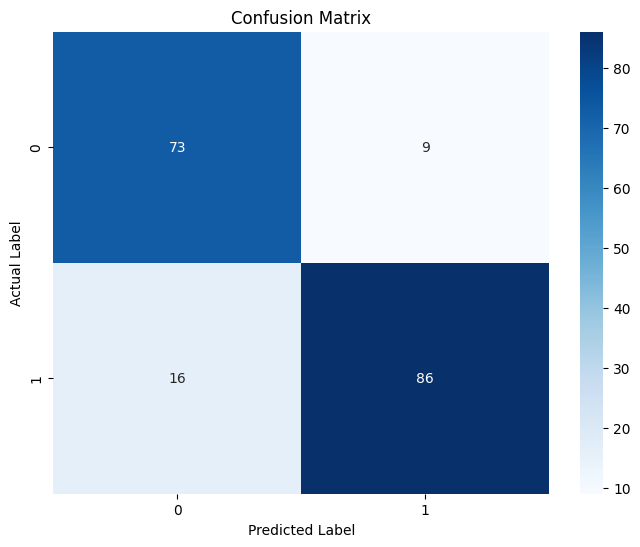

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

accuracy = accuracy_score(y_test, prediction_test)
f1 = f1_score(y_test, prediction_test)
conf_matrix = confusion_matrix(y_test, prediction_test)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()